In [1]:
%pip install --quiet --upgrade pip jupysql ipywidgets ipympl duckdb duckdb-engine pandas matplotlib jupyterlab pyarrow numpy scipy statsmodels tabulate

Note: you may need to restart the kernel to use updated packages.


In [2]:
import duckdb
import pandas as pd
idx = pd.IndexSlice
import ipywidgets as widgets
from matplotlib import pyplot as plt, dates, ticker
import numpy as np
%load_ext sql
%matplotlib widget
conn = duckdb.connect()
%sql conn --alias duckdb
pd.options.mode.copy_on_write = True

In [3]:
# set some matplotlib defaults
from matplotlib.dates import DateFormatter, MinuteLocator, SecondLocator, MicrosecondLocator
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
plt.rcParams['svg.fonttype'] = 'none'
# Set the global locator and formatter
plt.rcParams['date.autoformatter.microsecond'] = '%S.%f'  # Set the global format for microsecond level
plt.rcParams['date.autoformatter.second'] = '%H:%M:%S'  # Set the global format for second level
plt.rcParams['date.autoformatter.minute'] = '%H:%M'  # Set the global format for minute level
plt.rcParams['date.autoformatter.hour'] = '%Y-%m-%d %H:%M'  # Set the global format for hour level
plt.rcParams['date.autoformatter.day'] = '%Y-%m-%d %H:%M'  # Set the global format for day level
plt.rcParams['date.autoformatter.month'] = '%Y-%m-%d %H:%M'  # Set the global format for month level
plt.rcParams['date.autoformatter.year'] = '%Y-%m-%d %H:%M'  # Set the global format for year level

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20.colors)
plt.rcParams['legend.loc'] = "upper right"

In [4]:
%config SqlMagic.autopandas = True
%config SqlMagic.displaycon = False

In [5]:
%%sql
INSTALL sqlite;
LOAD sqlite;

,Success


In [6]:
%%sql
ATTACH './databases/404636.db' AS expdb (TYPE SQLITE) ;
USE expdb.main;

,Success


In [7]:
nodes = %sql SELECT * FROM expdb.Node
nodes

,node_deveui,node_appeui,node_appkey,board_id,radio_chipset,node_site,profile,riot_board,failed
0,70B3D57ED005EA59,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
1,70B3D57ED005EA60,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
2,70B3D57ED005EA61,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
3,70B3D57ED005EA62,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
4,70B3D57ED005EA63,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
5,70B3D57ED005EA64,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
6,70B3D57ED005EA65,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
7,70B3D57ED005EA66,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
8,70B3D57ED005EA67,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
9,70B3D57ED005EA68,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0


In [8]:
database = %sql select * from duckdb_databases()  where duckdb_databases.path like '%.db'
database

,database_name,database_oid,path,comment,tags,internal,type,readonly
0,expdb,1776,./databases/404636.db,None,"{'key': [], 'value': []}",False,sqlite,False


In [10]:
nodes_with_queries = %sql SELECT node_id, count(*) FROM expdb.Trace WHERE Trace.message like 'Execute Queries%' GROUP BY Trace.node_id;
nodes_with_queries


,node_id,count_star()


In [11]:
power_consumption= %sql select timestamp,power,current,voltage,node_id from expdb.Power_Consumption

#reduce memory consumption
power_consumption[["power", "current", "voltage"]] = power_consumption[["power", "current", "voltage"]].apply(pd.to_numeric, downcast="float")
power_consumption["node_id"] = power_consumption["node_id"].astype("category")
power_consumption.head()
#filter to only contain results where we have a query
power_consumption = power_consumption[power_consumption["node_id"].isin(nodes_with_queries["node_id"])]
#power_consumption = power_consumption.set_index(["node_id","timestamp"])
#power_consumption = power_consumption.sort_index()

In [12]:
power_consumption.memory_usage(deep=True)

Index           0
timestamp       0
power           0
current         0
voltage         0
node_id      1103
dtype: int64

In [12]:
import json
from pathlib import Path
EXP_ID = Path(database.loc[0, "path"]).stem
##find config file

EXP_CONFIG = json.load(open(next((Path.cwd() / "data" / str(EXP_ID)).glob("*.json"))))

In [13]:
print(f"""
EXPERIMENT OVERVIEW:

expid: {EXP_ID}
duration: {EXP_CONFIG["DURATION"]} minutes
epoch: {EXP_CONFIG["EXECUTION_EPOCH_S"]} seconds
sites used: {" ".join(nodes["node_site"].unique())}

Node overview:
{nodes.groupby(["node_site","riot_board"]).size().to_string()}
""")


EXPERIMENT OVERVIEW:

expid: 404631
duration: 60 minutes
epoch: 120 seconds
sites used: saclay

Node overview:
node_site  riot_board    
saclay     b-l072z-lrwan1    11



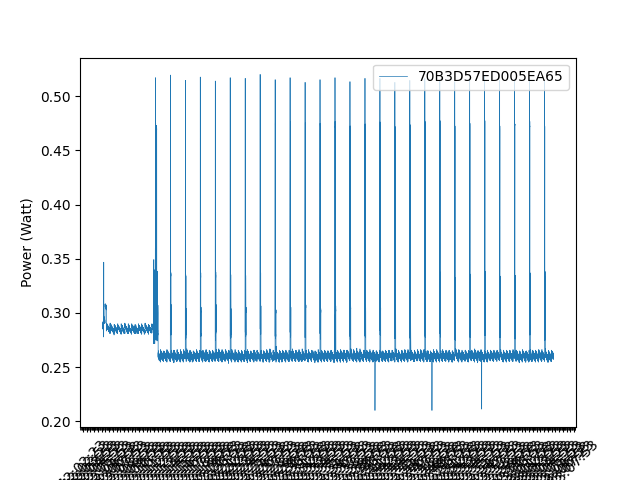

In [14]:
plt.figure()

for node_id, group in power_consumption.groupby("node_id", observed=True):
    idxs = np.linspace(0,len(group), 50000, endpoint=False, dtype=int)
    
    subset_power = group["power"].iloc[idxs]
    subset_timestamp = group["timestamp"].iloc[idxs]
    plt.plot(subset_timestamp, subset_power, label=node_id, linewidth=0.5)

plt.xlabel("Timestamp")
plt.xticks(rotation=45)
plt.ylabel("Power (Watt)")
plt.gca().xaxis.set_major_locator(SecondLocator(interval=30))  # Set the major locator to display labels every 30 seconds
plt.gca().xaxis.set_minor_locator(SecondLocator(interval=5))  # Set the minor locator to display labels at millisecond level
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M:%S')) 
#plt.gca().xaxis.set_minor_formatter(DateFormatter('%S.%f'))  
plt.legend()
plt.show()

## finding sync signals

In [15]:
BLINK_HIGH_MS = 200
BLINK_PRE_MS = 100
BLINK_POST_MS = 100

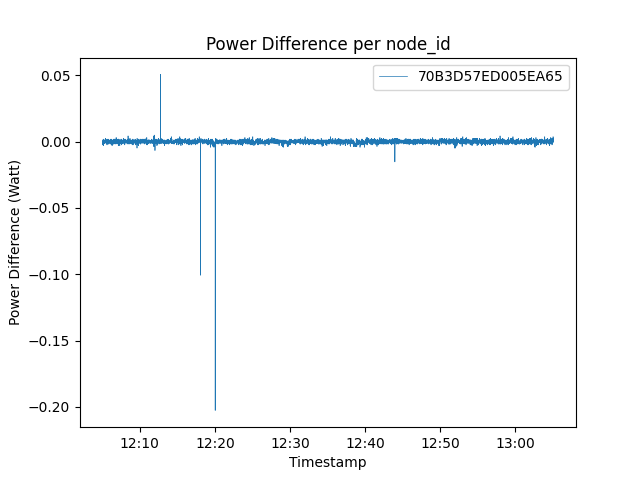

In [16]:
#diff of each group
power_consumption['power_diff'] = power_consumption.groupby("node_id", observed=True)["power"].diff()


plt.figure()
for node_id, group in power_consumption.groupby("node_id", observed=True):
    idxs = np.linspace(0,len(group), 5000, endpoint=False, dtype=int) # there are comparatively few but big jumps, so hard to see when just taking "random" indexes
    subset_power_diff = group["power_diff"].iloc[idxs]
    subset_timestamp = group["timestamp"].iloc[idxs]
    plt.plot(subset_timestamp, subset_power_diff, label=node_id, linewidth=0.5)
plt.title("Power Difference per node_id")
plt.xlabel("Timestamp")
plt.ylabel("Power Difference (Watt)")
plt.legend()
plt.show()

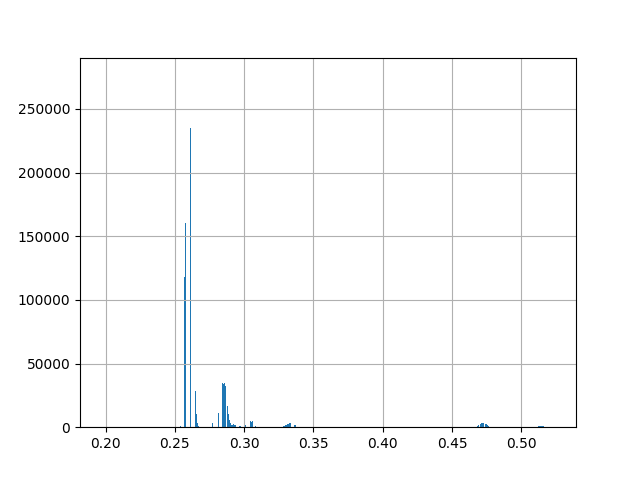

In [17]:
plt.figure()
power_consumption['power'].hist(bins=1000)
plt.show()

In [18]:
EDGE_SIZE = 0.07
rising_edge = power_consumption[power_consumption["power_diff"] > EDGE_SIZE].copy()
rising_edge.loc[:,'direction'] = 'rising'
falling_edge = power_consumption[power_consumption["power_diff"] < -EDGE_SIZE].copy()
falling_edge.loc[:,'direction'] = 'falling'
edges = pd.concat([rising_edge, falling_edge], verify_integrity=True)
edges.sort_index(inplace=True)
edges.head()

,timestamp,power,current,voltage,node_id,power_diff,direction
26216360,2024-09-02 12:12:03.503554,0.368114,0.073354,5.02250,70B3D57ED005EA65,0.079971,rising
26216366,2024-09-02 12:12:03.510175,0.391312,0.077921,5.02250,70B3D57ED005EA65,0.092181,rising
26216517,2024-09-02 12:12:03.676660,0.517680,0.103170,5.01875,70B3D57ED005EA65,0.230758,rising
26216698,2024-09-02 12:12:03.876222,0.428551,0.085344,5.02250,70B3D57ED005EA65,-0.084855,falling
26216699,2024-09-02 12:12:03.877320,0.281427,0.055968,5.02250,70B3D57ED005EA65,-0.147124,falling


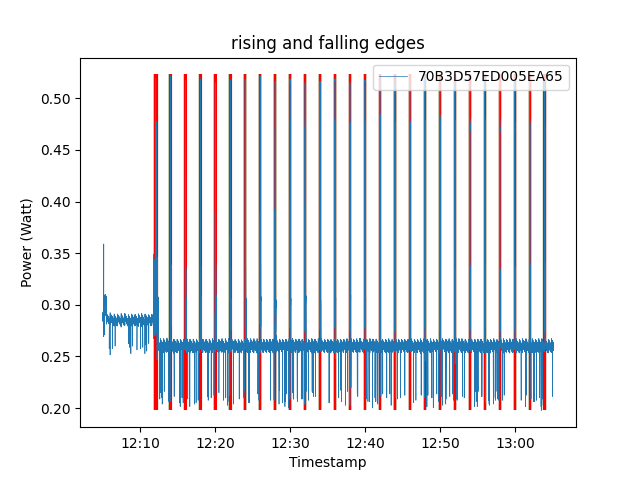

In [19]:
# plot the edges in an example
node_id = power_consumption["node_id"].iloc[0]
to_plot = power_consumption[power_consumption["node_id"] == node_id]
low_point = to_plot["power"].min()
high_point = to_plot["power"].max()
plt.figure()
plt.vlines(rising_edge[rising_edge["node_id"] == node_id]["timestamp"], ymin=low_point, ymax=high_point, color='green')
plt.vlines(falling_edge.loc[falling_edge["node_id"] == node_id, "timestamp"], ymin=low_point, ymax=high_point, color='red')
plt.plot(to_plot["timestamp"], to_plot["power"], label=node_id, linewidth=0.5)

plt.title("rising and falling edges")
plt.xlabel("Timestamp")
plt.ylabel("Power (Watt)")
plt.legend()
plt.show()

In [20]:
# populate edges with next direction and timestamps to later filter out edges that are too close to each other.
# need the index as dedicated column for this to be possible as a groupby transformation

edges['next_direction'] = edges.groupby('node_id', observed=True)['direction'].shift(-1)
edges['next_timestamp'] = edges.groupby('node_id', observed=True)['timestamp'].shift(-1)
edges.head()

,timestamp,power,current,voltage,node_id,power_diff,direction,next_direction,next_timestamp
26216360,2024-09-02 12:12:03.503554,0.368114,0.073354,5.02250,70B3D57ED005EA65,0.079971,rising,rising,2024-09-02 12:12:03.510175
26216366,2024-09-02 12:12:03.510175,0.391312,0.077921,5.02250,70B3D57ED005EA65,0.092181,rising,rising,2024-09-02 12:12:03.676660
26216517,2024-09-02 12:12:03.676660,0.517680,0.103170,5.01875,70B3D57ED005EA65,0.230758,rising,falling,2024-09-02 12:12:03.876222
26216698,2024-09-02 12:12:03.876222,0.428551,0.085344,5.02250,70B3D57ED005EA65,-0.084855,falling,falling,2024-09-02 12:12:03.877320
26216699,2024-09-02 12:12:03.877320,0.281427,0.055968,5.02250,70B3D57ED005EA65,-0.147124,falling,rising,2024-09-02 12:12:04.079110


In [21]:
# filter out edges that are too close to each other or too far apart. We add 5% tolerance
edges = edges[(edges['direction'] == "rising") & (edges['next_direction'] == "falling") & ((edges['next_timestamp'] - edges["timestamp"] < pd.Timedelta(milliseconds=BLINK_HIGH_MS + (BLINK_HIGH_MS/40)))  & (edges['next_timestamp'] - edges["timestamp"] > pd.Timedelta(milliseconds=BLINK_HIGH_MS - (BLINK_HIGH_MS/40))))]

# filter out edges where the consumption between them is not relatively constant
#edges[['node_id','timestamp', 'next_timestamp']].apply(lambda x: power_consumption[(power_consumption['node_id'] == x['node_id']) & (power_consumption['timestamp'] >= x['timestamp']) & (power_consumption['timestamp'] <= x['next_timestamp'])]["power"].diff().mean() < 0.1, axis=1)

edges.head()

,timestamp,power,current,voltage,node_id,power_diff,direction,next_direction,next_timestamp
26216517,2024-09-02 12:12:03.676660,0.517680,0.103170,5.01875,70B3D57ED005EA65,0.230758,rising,falling,2024-09-02 12:12:03.876222
26216883,2024-09-02 12:12:04.080208,0.516459,0.103023,5.01625,70B3D57ED005EA65,0.077530,rising,falling,2024-09-02 12:12:04.279770
26324945,2024-09-02 12:14:03.229759,0.462127,0.092035,5.01500,70B3D57ED005EA65,0.183752,rising,falling,2024-09-02 12:14:03.430419
26325311,2024-09-02 12:14:03.633307,0.519511,0.103609,5.01625,70B3D57ED005EA65,0.153228,rising,falling,2024-09-02 12:14:03.832869
26433510,2024-09-02 12:16:02.934604,0.516459,0.102950,5.01875,70B3D57ED005EA65,0.169101,rising,falling,2024-09-02 12:16:03.134165


In [22]:
## add sync signal start and end times
edges.loc[:, 'sync_start'] = edges["timestamp"] - pd.Timedelta(milliseconds=100)
edges.loc[:, 'sync_end'] = edges.next_timestamp + pd.Timedelta(milliseconds=100)
edges.head()

,timestamp,power,current,voltage,node_id,power_diff,direction,next_direction,next_timestamp,sync_start,sync_end
26216517,2024-09-02 12:12:03.676660,0.517680,0.103170,5.01875,70B3D57ED005EA65,0.230758,rising,falling,2024-09-02 12:12:03.876222,2024-09-02 12:12:03.576660,2024-09-02 12:12:03.976222
26216883,2024-09-02 12:12:04.080208,0.516459,0.103023,5.01625,70B3D57ED005EA65,0.077530,rising,falling,2024-09-02 12:12:04.279770,2024-09-02 12:12:03.980208,2024-09-02 12:12:04.379770
26324945,2024-09-02 12:14:03.229759,0.462127,0.092035,5.01500,70B3D57ED005EA65,0.183752,rising,falling,2024-09-02 12:14:03.430419,2024-09-02 12:14:03.129759,2024-09-02 12:14:03.530419
26325311,2024-09-02 12:14:03.633307,0.519511,0.103609,5.01625,70B3D57ED005EA65,0.153228,rising,falling,2024-09-02 12:14:03.832869,2024-09-02 12:14:03.533307,2024-09-02 12:14:03.932869
26433510,2024-09-02 12:16:02.934604,0.516459,0.102950,5.01875,70B3D57ED005EA65,0.169101,rising,falling,2024-09-02 12:16:03.134165,2024-09-02 12:16:02.834604,2024-09-02 12:16:03.234165


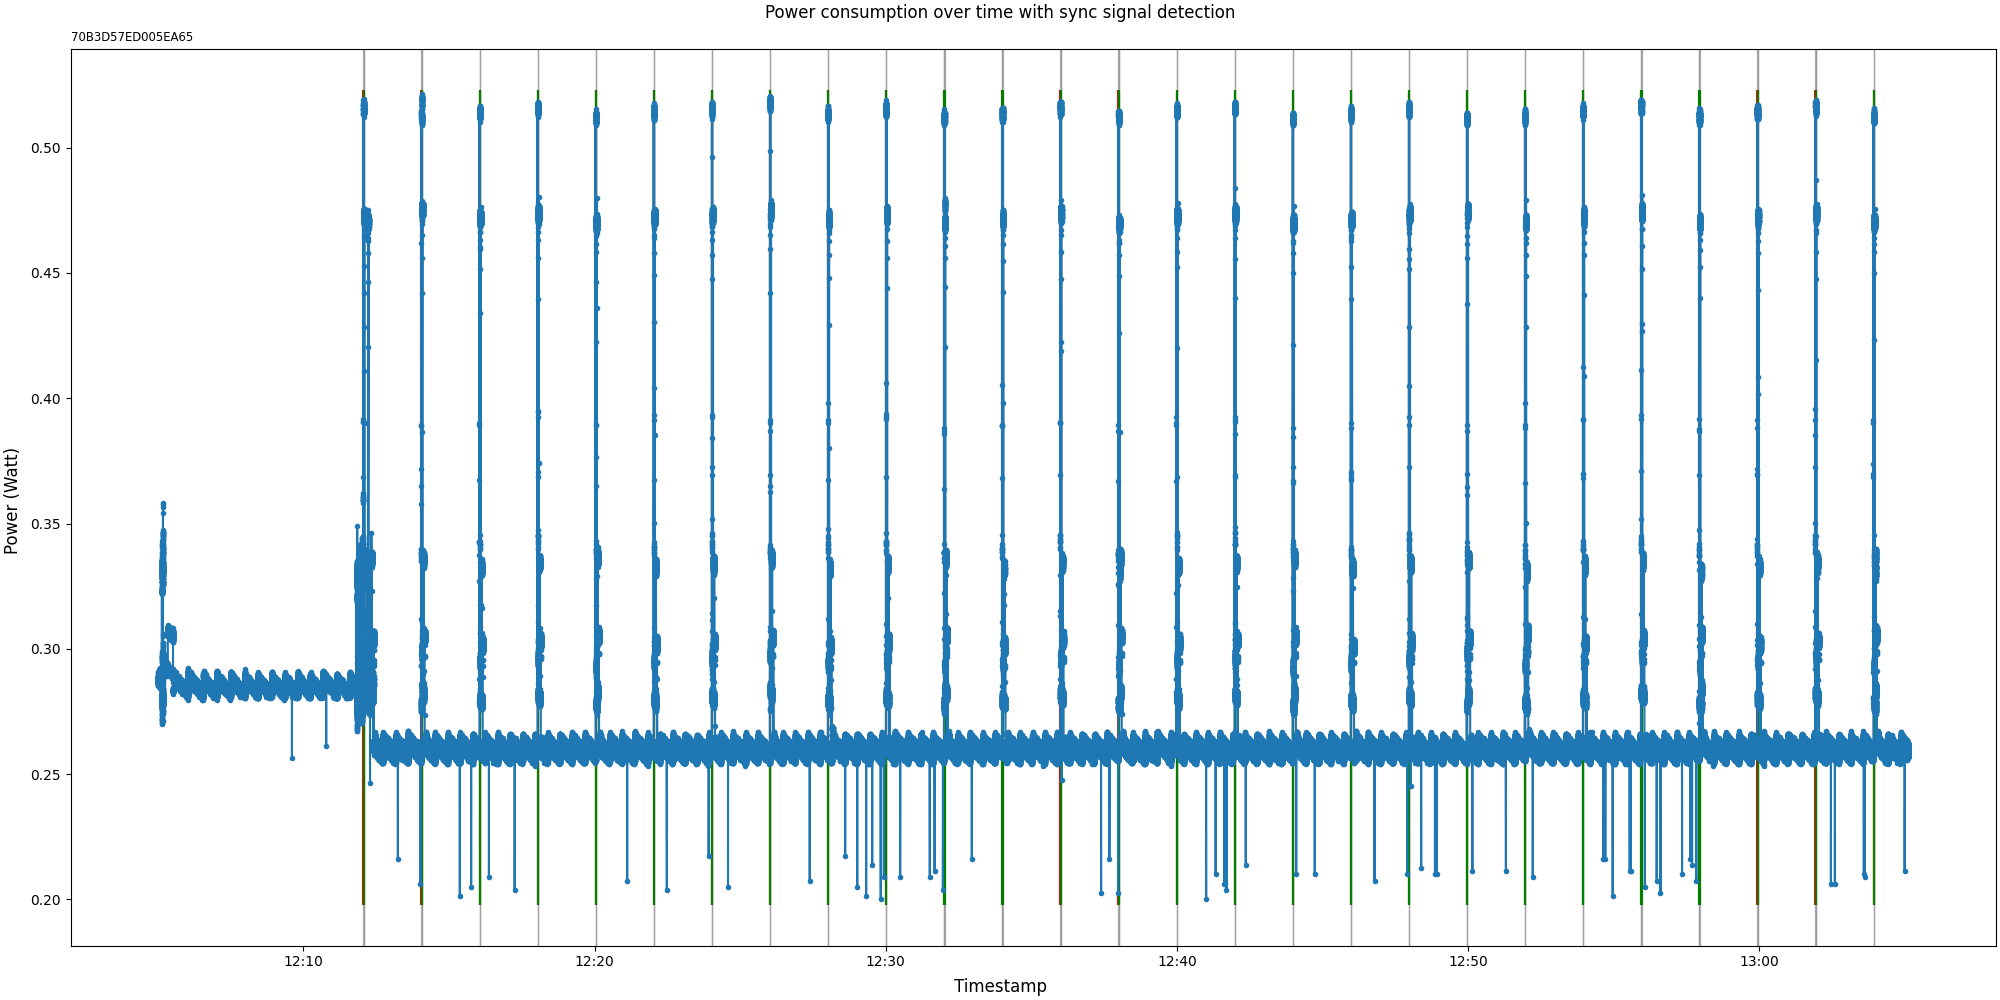

In [23]:
groups_by_node_id = power_consumption.groupby('node_id', observed=True)
edges_by_node_id = edges.groupby('node_id', observed=True)

fig, axs = plt.subplots(len(groups_by_node_id), 1, sharex=True, sharey=True, layout='constrained', figsize=(20, 10))
## axs is not a list if there is only a single group, so we need to wrap it in a list
if not isinstance(axs, list) and not isinstance(axs, np.ndarray):
    axs = [axs]

low_point = power_consumption["power"].min()
high_point = power_consumption["power"].max()

fig.supxlabel("Timestamp")
fig.supylabel("Power (Watt)")
fig.suptitle("Power consumption over time with sync signal detection")
for ((node_id, group), ax) in zip(groups_by_node_id, axs):
    if node_id in edges_by_node_id.groups:
        edges_grouped = edges_by_node_id.get_group(node_id)

        ax.vlines(edges_grouped['timestamp'], ymin=low_point, ymax=high_point, color='red')
        ax.vlines(edges_grouped['next_timestamp'], ymin=low_point, ymax=high_point, color='green')
        for row in edges_by_node_id.get_group(node_id).itertuples():
            ax.axvspan(row.sync_start, row.sync_end, color='grey', alpha=0.5)

    else:
        print(f"Node {node_id} has no edges")
    idxs = np.linspace(0, len(group), endpoint=False, num=1000000, dtype=int)
    subset_power = group["power"].iloc[idxs]
    subset_timestamp = group["timestamp"].iloc[idxs]
    ax.plot(subset_timestamp, subset_power, label=node_id, marker='.')
    ax.set_title(node_id, fontsize='small', loc='left')
plt.show()

In [24]:
# every loop starts with 2 sync signals right after each other
# find all sync signals where the next start is very close to previous end
grouped = edges.groupby('node_id', observed=True)
edges['next_sync_start'] = grouped['sync_start'].shift(-1)
edges['next_sync_end'] = grouped['sync_end'].shift(-1)
loops = edges[((edges['next_sync_start'] - edges['sync_end']) < pd.Timedelta(milliseconds=500)) & ((edges['next_sync_start'] - edges['sync_end']) > pd.Timedelta(milliseconds=0))][['node_id', 'sync_start', 'next_sync_end']].copy()
print(loops.columns)
loops.rename(columns={'sync_start': 'loop_signal_start', 'next_sync_end': 'loop_signal_end'}, inplace=True)

#filter out loops where the sync signals are too close to each other given the known duration of loops
#loops = loops[loops.groupby('node_id')["loop_signal_start"].diff() > pd.Timedelta(seconds=EXP_CONFIG["EXECUTION_EPOCH_S"]*0.5)]

loops['loop_num'] = loops.groupby('node_id', observed=True).cumcount()


## find any loops where the duration is higher than the expected duration. This should either be empty or only contain loop 0 loops
loops[loops.groupby('node_id', observed=True)["loop_signal_start"].diff() > pd.Timedelta(seconds=EXP_CONFIG["EXECUTION_EPOCH_S"]*1.5)]


Index(['node_id', 'sync_start', 'next_sync_end'], dtype='object')


,node_id,loop_signal_start,loop_signal_end,loop_num


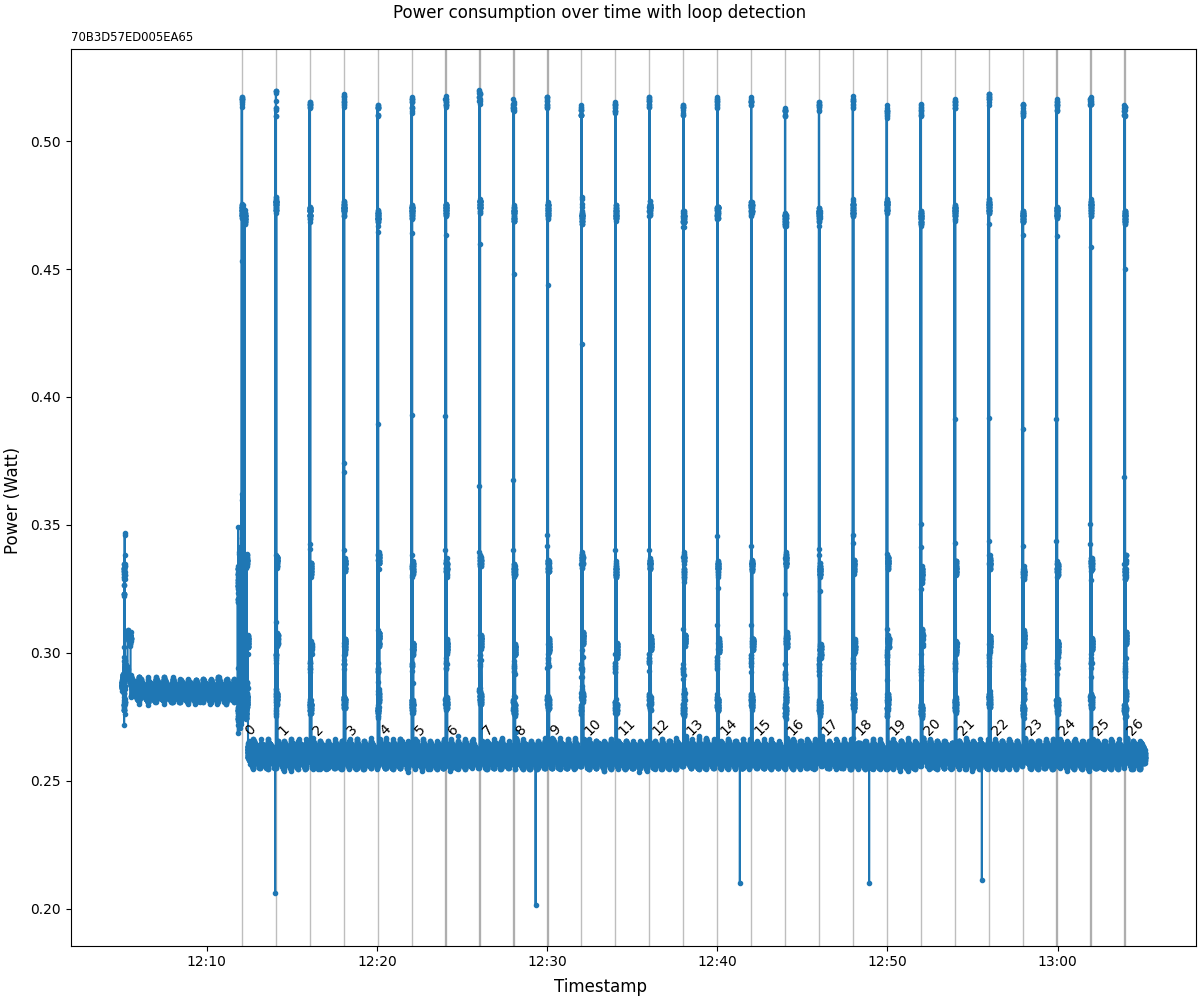

In [25]:

groups_by_node_id = power_consumption.groupby('node_id', observed=True)
loops_by_node_id = loops.groupby('node_id', observed=True)
fig, axs = plt.subplots(len(groups_by_node_id), 1, sharex=True, sharey=True, figsize=(12, 10), layout='constrained')
text_y_pos = power_consumption['power'].mean()
fig.supxlabel("Timestamp")
fig.supylabel("Power (Watt)")
fig.suptitle("Power consumption over time with loop detection")
## axs is not a list if there is only a single group, so we need to wrap it in a list'
if not isinstance(axs, list) and not isinstance(axs, np.ndarray):
    axs = [axs]
for ((node_id, group), ax) in zip(groups_by_node_id, axs):
    if node_id in loops_by_node_id.groups:
        loops_group = loops_by_node_id.get_group(node_id)
        for row in loops_group.itertuples():
            ax.axvspan(row.loop_signal_start, row.loop_signal_end, color='tab:gray', alpha=0.5, label="loop signal")
            ax.text(row.loop_signal_end, text_y_pos, f"{row.loop_num}", rotation=45)
    else:
        print(f"Node {node_id} has no loops")
    idxs = np.linspace(0, len(group), endpoint=False, num=100000, dtype=int)
    subset_power = group["power"].iloc[idxs]
    subset_timestamp = group["timestamp"].iloc[idxs]
    ax.plot(subset_timestamp, subset_power,label=node_id, marker='.')
    ax.set_title(node_id, fontsize='small', loc='left')

plt.show()

In [26]:
%%sql timings << SELECT 
    node_id,
    timestamp,
    regexp_extract(message, 'Loop: (-?[0-9]+)',1) as loop_num,
    regexp_extract(message, '.*Sync: (-?[0-9]+)',1) as sync_time_ms,
    regexp_extract(message, '.*Load: (-?[0-9]+)',1) as load_time_ms,
    regexp_extract(message, '.*deserialize: (-?[0-9]+)',1) as deserialize_time_ms,
    regexp_extract(message, '.*sensor init: (-?[0-9]+)',1) as sensor_init_time_ms,
    regexp_extract(message, '.*net init: (-?[0-9]+)',1) as net_init_time_ms,
    --regexp_extract(message, '.*Listen: (-?[0-9]+)',1) as listen_time_ms,
    regexp_extract(message, '.*Collect: (-?[0-9]+)',1) as collect_time_ms,
    regexp_extract(message, '.*Exec tflite: (-?[0-9]+)',1) as exec_tflite_time_ms,
    regexp_extract(message, '.*Exec query: (-?[0-9]+)',1) as exec_query_time_ms,
    regexp_extract(message, '.*Send: (-?[0-9]+)',1) as send_time_ms,
    regexp_extract(message, '.*save config: (-?[0-9]+)',1) as save_config_time_ms,
    regexp_extract(message, '.*Sleep: (-?[0-9]+)',1) as sleep_time_s
FROM expdb.Trace
WHERE message LIKE 'TIMINGS>%'

In [27]:
# 'TIMINGS> Loop: 0, Sync: 806 ms, Load: 40 ms, sensor init: 10 ms, env init: 0 ms, net init: 5216 ms, Collect: -1 ms, Exec: -1 ms, Send: 5119 ms, save config: 2646 ms, Sleep: 9 s\n'
timings['node_id'].unique()

array(['70B3D57ED005EA60', '70B3D57ED005EA65', '70B3D57ED005EA66',
       '70B3D57ED005EA69', '70B3D57ED005EA62', '70B3D57ED005EA64',
       '70B3D57ED005EA59', '70B3D57ED005EA61', '70B3D57ED005EA63',
       '70B3D57ED005EA68', '70B3D57ED005EA67'], dtype=object)

In [28]:
# since duckdb return all columns as object we need to change types before we can merge

timings[['loop_num', 'sync_time_ms', 'load_time_ms', 'deserialize_time_ms', 'sensor_init_time_ms', 'net_init_time_ms', 'collect_time_ms', 'exec_tflite_time_ms', 'exec_query_time_ms', 'send_time_ms', 'save_config_time_ms', 'sleep_time_s']] = timings[['loop_num', 'sync_time_ms', 'load_time_ms', 'deserialize_time_ms', 'sensor_init_time_ms', 'net_init_time_ms', 'collect_time_ms', 'exec_tflite_time_ms', 'exec_query_time_ms', 'send_time_ms', 'save_config_time_ms', 'sleep_time_s']].apply(pd.to_numeric)

# .. and merge. here we need to reset index first, since df.merge doesnt preserve index
loops = loops.reset_index().merge(timings, on=['node_id', 'loop_num'], validate="many_to_one").set_index('loop_signal_start')
loops.head()

,index,node_id,loop_signal_end,loop_num,timestamp,sync_time_ms,load_time_ms,deserialize_time_ms,sensor_init_time_ms,net_init_time_ms,collect_time_ms,exec_tflite_time_ms,exec_query_time_ms,send_time_ms,save_config_time_ms,sleep_time_s
loop_signal_start,,,,,,,,,,,,,,,,
2024-09-02 12:12:03.576660,26216517,70B3D57ED005EA65,2024-09-02 12:12:04.379770,0,2024-09-02 12:12:25.036983,806,125,2,0,8425,10,0,0,9866,2205,98
2024-09-02 12:14:03.129759,26324945,70B3D57ED005EA65,2024-09-02 12:14:03.932869,1,2024-09-02 12:14:09.742358,805,125,83,13,53,15,0,2,4039,1455,113
2024-09-02 12:16:02.834604,26433510,70B3D57ED005EA65,2024-09-02 12:16:03.637714,2,2024-09-02 12:16:09.444767,805,125,83,13,53,15,0,2,4038,1454,113
2024-09-02 12:18:02.537404,26542073,70B3D57ED005EA65,2024-09-02 12:18:03.340514,3,2024-09-02 12:18:09.149305,805,125,83,13,53,14,0,3,4039,1455,113
2024-09-02 12:20:02.242707,26650638,70B3D57ED005EA65,2024-09-02 12:20:03.044779,4,2024-09-02 12:20:08.853632,805,125,83,13,53,15,0,2,4039,1454,113


In [29]:
# this is just verifying that the 0th loop has the highest save times. Since this is where we get our query
loops[["node_id","loop_num", "save_config_time_ms"]].sort_values(by="save_config_time_ms", ascending=False)

,node_id,loop_num,save_config_time_ms
loop_signal_start,,,
2024-09-02 12:12:03.576660,70B3D57ED005EA65,0,2205
2024-09-02 12:18:02.537404,70B3D57ED005EA65,3,1455
2024-09-02 12:57:56.609466,70B3D57ED005EA65,23,1455
2024-09-02 12:32:00.464148,70B3D57ED005EA65,10,1455
2024-09-02 12:34:00.167712,70B3D57ED005EA65,11,1455
2024-09-02 12:14:03.129759,70B3D57ED005EA65,1,1455
2024-09-02 12:43:58.685315,70B3D57ED005EA65,16,1454
2024-09-02 13:01:56.018271,70B3D57ED005EA65,25,1454
2024-09-02 12:59:56.313945,70B3D57ED005EA65,24,1454


In [30]:

loops["start_time"] = loops.index
loops["sync_start"] = loops["start_time"]
loops["sync_end"] = loops["sync_start"] + pd.to_timedelta(loops["sync_time_ms"], unit="ms")
loops["load_start"] = loops["sync_end"]
loops["load_end"] = loops["load_start"] + pd.to_timedelta(loops["load_time_ms"], unit="ms")
loops["deserialize_start"] = loops["load_end"]
loops["deserialize_end"] = loops["deserialize_start"] + pd.to_timedelta(loops["deserialize_time_ms"], unit="ms")
loops["sensor_init_start"] = loops["deserialize_end"]
loops["sensor_init_end"] = loops["sensor_init_start"] + pd.to_timedelta(loops["sensor_init_time_ms"], unit="ms")
loops["net_init_start"] = loops["sensor_init_end"]
loops["net_init_end"] = loops["net_init_start"] + pd.to_timedelta(loops["net_init_time_ms"], unit="ms")
loops["collect_time_start"] = loops["net_init_end"]
loops["collect_time_end"] = loops["collect_time_start"] +pd.to_timedelta(loops["collect_time_ms"], unit="ms")
loops["exec_tflite_start"] = loops["collect_time_end"]
loops["exec_tflite_end"] = loops["exec_tflite_start"] + pd.to_timedelta(loops["exec_tflite_time_ms"], unit="ms")
loops["exec_query_start"] = loops["exec_tflite_end"]
loops["exec_query_end"] = loops["exec_query_start"] + pd.to_timedelta(loops["exec_query_time_ms"], unit="ms")
loops["send_start"] = loops["exec_query_end"]
loops["send_end"] = loops["send_start"] +pd.to_timedelta(loops["send_time_ms"], unit="ms")
loops["save_config_start"] = loops["send_end"]
loops["save_config_end"] = loops["save_config_start"] + pd.to_timedelta(loops["save_config_time_ms"], unit="ms")
loops["sleep_start"] = loops["save_config_end"]
loops["sleep_end"] = loops["sleep_start"] + pd.to_timedelta(loops["sleep_time_s"], unit="s")

# there is a bit of space between sleep end and the next loop start. This is the riot os initialisation time. we also mark that
# NOTE: this is not a perfect solution as it doesnt include the very first riot os initialization time. but it is good enough for now
for node_id in loops["node_id"].unique():
    loops.loc[loops["node_id"] == node_id, "riotos_init_start"] = loops.loc[loops["node_id"] == node_id, "sleep_end"].shift(1)
    loops.loc[loops["node_id"] == node_id, "riotos_init_end"] = loops.loc[loops["node_id"] == node_id, "start_time"]

loops.replace(-1,0) # remove -1 values. They show up if the time measurement is not available

loops.iloc[1]

index                                    26324945
node_id                          70B3D57ED005EA65
loop_signal_end        2024-09-02 12:14:03.932869
loop_num                                        1
timestamp              2024-09-02 12:14:09.742358
sync_time_ms                                  805
load_time_ms                                  125
deserialize_time_ms                            83
sensor_init_time_ms                            13
net_init_time_ms                               53
collect_time_ms                                15
exec_tflite_time_ms                             0
exec_query_time_ms                              2
send_time_ms                                 4039
save_config_time_ms                          1455
sleep_time_s                                  113
start_time             2024-09-02 12:14:03.129759
sync_start             2024-09-02 12:14:03.129759
sync_end               2024-09-02 12:14:03.934759
load_start             2024-09-02 12:14:03.934759


In [31]:
# Here we add activity category and the loop number to each power_consumption measurements. Lots of tracking need to be done to make sure we do it correctly per node_id
# and to add activities which we cannot track using the timing traces. I.e. the riot initialisation

# temp set index of power consumption to make below operation much faster
#power_consumption.drop(columns=["activity","loop_num"], inplace=True)
power_consumption = power_consumption.set_index(["node_id","timestamp"])
power_consumption = power_consumption.sort_index()

for loop in loops.itertuples(name="Loop"):
    print(loop)
    # Note: that the loop number is only ansigned for the actual terra loop. The riotos init time does not get a loop number
    power_consumption.loc[idx[loop.node_id, loop.sync_start:loop.sync_end], "activity"]                 = "sync"
    power_consumption.loc[idx[loop.node_id, loop.load_start:loop.load_end], "activity"]                 = "load"
    power_consumption.loc[idx[loop.node_id, loop.deserialize_start:loop.deserialize_end], "activity"]   = "deserialize"
    power_consumption.loc[idx[loop.node_id, loop.sensor_init_start:loop.sensor_init_end], "activity"]   = "sensor_init"
    power_consumption.loc[idx[loop.node_id, loop.net_init_start:loop.net_init_end], "activity"]         = "net_init"
    power_consumption.loc[idx[loop.node_id, loop.collect_time_start:loop.collect_time_end], "activity"] = "collect"
    power_consumption.loc[idx[loop.node_id, loop.exec_tflite_start:loop.exec_tflite_end], "activity"]   = "exec_tflite"
    power_consumption.loc[idx[loop.node_id, loop.exec_query_start:loop.exec_query_end], "activity"]     = "exec_query"
    power_consumption.loc[idx[loop.node_id, loop.send_start:loop.send_end], "activity"]                 = "send"
    power_consumption.loc[idx[loop.node_id, loop.save_config_start:loop.save_config_end], "activity"]   = "save_config"
    power_consumption.loc[idx[loop.node_id, loop.sleep_start:loop.sleep_end], "activity"]               = "sleep"
    power_consumption.loc[idx[loop.node_id, loop.riotos_init_start:loop.riotos_init_end], "activity"]   = "riot_os_init"
    if int(loop.loop_num) == 0:
        power_consumption.loc[idx[loop.node_id, loop.sync_start:loop.sleep_end], "loop_num"]            = 0
    else:
        power_consumption.loc[idx[loop.node_id, loop.riotos_init_start:loop.sleep_end], "loop_num"]         = int(loop.loop_num)



power_consumption["activity"] = power_consumption["activity"].fillna("uncategorised")
power_consumption["activity"] = power_consumption["activity"].astype("category")


#remove the index again to make it more natural to access the node_id and timestamp columns
power_consumption = power_consumption.reset_index()

Loop(Index=Timestamp('2024-09-02 12:12:03.576660'), index=26216517, node_id='70B3D57ED005EA65', loop_signal_end=Timestamp('2024-09-02 12:12:04.379770'), loop_num=0, timestamp=Timestamp('2024-09-02 12:12:25.036983'), sync_time_ms=806, load_time_ms=125, deserialize_time_ms=2, sensor_init_time_ms=0, net_init_time_ms=8425, collect_time_ms=10, exec_tflite_time_ms=0, exec_query_time_ms=0, send_time_ms=9866, save_config_time_ms=2205, sleep_time_s=98, start_time=Timestamp('2024-09-02 12:12:03.576660'), sync_start=Timestamp('2024-09-02 12:12:03.576660'), sync_end=Timestamp('2024-09-02 12:12:04.382660'), load_start=Timestamp('2024-09-02 12:12:04.382660'), load_end=Timestamp('2024-09-02 12:12:04.507660'), deserialize_start=Timestamp('2024-09-02 12:12:04.507660'), deserialize_end=Timestamp('2024-09-02 12:12:04.509660'), sensor_init_start=Timestamp('2024-09-02 12:12:04.509660'), sensor_init_end=Timestamp('2024-09-02 12:12:04.509660'), net_init_start=Timestamp('2024-09-02 12:12:04.509660'), net_init

In [32]:
power_consumption.groupby("activity", observed=True)["power"].count()

activity
collect              372
deserialize         1964
exec_query            53
load                3063
net_init            8881
riot_os_init        2726
save_config        36296
send              104161
sensor_init          296
sleep            2710028
sync               19711
uncategorised     383327
Name: power, dtype: int64

In [33]:
#save this in a parquet file for later analysis
power_consumption[["node_id","timestamp","power","current","voltage","activity","loop_num"]].to_parquet(f"./parquets/{EXP_ID}.parquet")

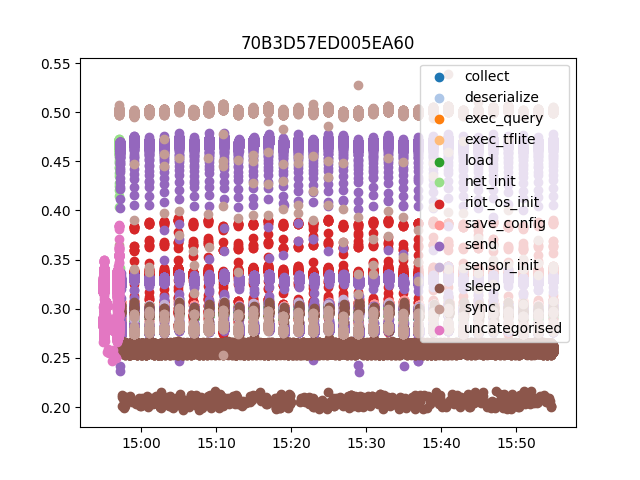

In [34]:
# plot a single nodes consumption where activity indicates colour'
plt.figure()
node_id = power_consumption["node_id"].unique()[1]
to_plot = power_consumption[node_id == power_consumption["node_id"]].groupby("activity", observed=True)
for name, group in to_plot:
    plt.scatter(group["timestamp"], group["power"], label=name)
    plt.title(node_id)
    plt.legend()
plt.show()

In [35]:
# TODO: maybe do some analysis on the riot_os initialisation

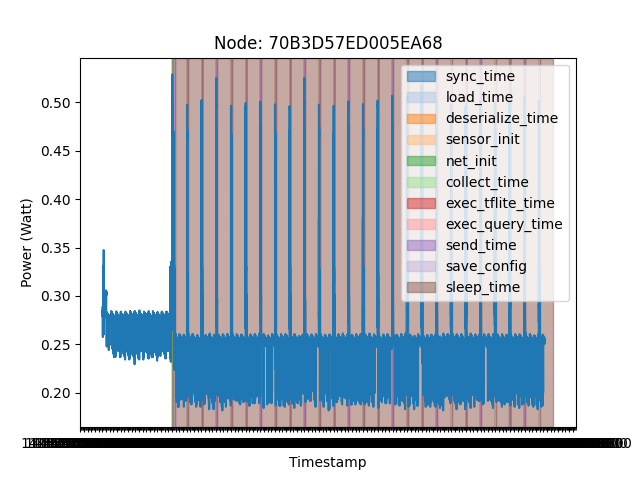

In [36]:
node_id = nodes_with_queries.iloc[-1]["node_id"]
timing_data = loops[loops["node_id"] == node_id]
power_data = power_consumption[power_consumption["node_id"] == node_id]

plt.figure()
plt.plot(power_data["timestamp"], power_data["power"])
alpha = 0.5
for row in timing_data.itertuples():
    plt.axvspan(row.sync_start, row.sync_end, alpha=alpha, label="sync_time", color=plt.cm.tab20(0))
    plt.axvspan(row.load_start, row.load_end, alpha=alpha, label="load_time", color=plt.cm.tab20(1))
    plt.axvspan(row.deserialize_start, row.deserialize_end, alpha=alpha, label="deserialize_time", color=plt.cm.tab20(2))
    plt.axvspan(row.sensor_init_start, row.sensor_init_end, alpha=alpha, label="sensor_init", color=plt.cm.tab20(3))
    plt.axvspan(row.net_init_start, row.net_init_end, alpha=alpha, label="net_init", color=plt.cm.tab20(4))
    plt.axvspan(row.collect_time_start, row.collect_time_end, alpha=alpha, label="collect_time", color=plt.cm.tab20(5))
    plt.axvspan(row.exec_tflite_start, row.exec_tflite_end, alpha=alpha, label="exec_tflite_time", color=plt.cm.tab20(6))
    plt.axvspan(row.exec_query_start, row.exec_query_end, alpha=alpha, label="exec_query_time", color=plt.cm.tab20(7))
    plt.axvspan(row.send_start, row.send_end, alpha=alpha, label="send_time", color=plt.cm.tab20(8))
    plt.axvspan(row.save_config_start, row.save_config_end, alpha=alpha, label="save_config", color=plt.cm.tab20(9))
    plt.axvspan(row.sleep_start, row.sleep_end, alpha=alpha, label="sleep_time", color=plt.cm.tab20(10))
# this to remove duplicate labels https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.gca().xaxis.set_major_locator(SecondLocator(interval=30))
plt.gca().xaxis.set_minor_locator(SecondLocator(interval=5))
plt.title(f"Node: {node_id}")
plt.xlabel("Timestamp")
plt.ylabel("Power (Watt)")
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M:%S.%f'))  # Set the date format for the tick labels
plt.show()


## Add events if any

In [37]:
# get all relevant frame-events
%sql send_frame_start << select * from expdb.Trace WHERE message LIKE '%send frame%'
%sql send_frame_end << select * from expdb.Trace WHERE message LIKE '%Transmission completed%'
%sql receive_frame_start << select * from expdb.Trace WHERE message LIKE '%RX started%'
%sql receive_frame_end << select * from expdb.Trace WHERE message LIKE '%received something%'

print(f"{len(send_frame_start)} send frame start events. {len(send_frame_end)} end events. {len(receive_frame_start)} receive frame start events. {len(receive_frame_end)} end events.")

0 send frame start events. 0 end events. 0 receive frame start events. 0 end events.


In [38]:
#drop first row of send_frame_end and receive_frame_start since thats from the join procedure
send_frame_end = send_frame_end.iloc[1:]
receive_frame_start = receive_frame_start.iloc[1:]

# confirm the 2 pairs of start/end all have the same length
#assert len(send_frame_start) == len(send_frame_end), f"send frame event mismatch. start {len(send_frame_start)}, end { len(send_frame_end)}"
#assert len(receive_frame_start) == len(receive_frame_end), f"receive frame event mismatch  {len(receive_frame_start)}, end { len(receive_frame_end)}"

In [39]:
# add send and receive columns to plot
#TODO: update this to support more nodes
# for send_start_row, send_end_row in zip(send_frame_start.itertuples(), send_frame_end.itertuples()):
#     start_time = send_start_row.timestamp
#     end_time = send_end_row.timestamp
#     plt.axvspan(start_time, end_time, color='tab:pink', alpha=0.5, label="send_events")

# for receive_frame_start, receive_frame_end in zip(receive_frame_start.itertuples(), receive_frame_end.itertuples()):
#     start_time = receive_frame_start.timestamp
#     end_time = receive_frame_end.timestamp
#     plt.axvspan(start_time, end_time, color='tab:brown', alpha=0.5, label="receive_events")


# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# plt.show()

In [40]:
%sql SELECT * from expdb.Content_Message

,content_message_id,frame_counter,frame_port,frame_payload
0,2,-1,1,Cg4KDAoKCggKAggBCgIQAA==
1,3,0,2,PDM=
2,5,-1,1,Cg4KDAoKCggKAggBCgIQAA==
3,6,0,2,PDM=
4,8,-1,1,Cg4KDAoKCggKAggBCgIQAA==
...,...,...,...,...
281,294,29,2,CgMglhU=
282,295,28,2,CgMgyBU=
283,296,26,2,CgMgqhU=
284,297,29,2,CgMgoBU=


In [41]:
%%sql
SELECT
    through_gateway,
    gateway_received_at,
    app_received_at,
    rssi,
    snr,
    bandwidth,
    frequency,
    consumed_airtime_s,
    spreading_factor,
    coding_rate,
    frame_counter,
    frame_port,
    frame_payload,
    from_base64(frame_payload) as decoded_payload,
    related_node,
    network_received_at
FROM
    expdb.Uplink_Message,
    expdb.Content_Message,
    expdb.Message 
WHERE
    Uplink_Message.uplink_message_id = Message.message_id AND
    Content_Message.content_message_id = Message.message_id

,through_gateway,gateway_received_at,app_received_at,rssi,snr,bandwidth,frequency,consumed_airtime_s,spreading_factor,coding_rate,frame_counter,frame_port,frame_payload,decoded_payload,related_node,network_received_at
0,iot-lab-saclay-gateway,2024-08-30 14:56:44,2024-08-30 14:56:44.825925,-53,7.75,125000,867500000,1.155072,SF12,4/5,0,2,PDM=,"[60, 51]",70B3D57ED005EA59,2024-08-30 14:56:44.618711
1,gw-tetech-test,2024-08-30 14:57:11,2024-08-30 14:57:11.822070,-121,-10.20,125000,867300000,1.155072,SF12,4/5,0,2,PDM=,"[60, 51]",70B3D57ED005EA60,2024-08-30 14:57:11.609014
2,gw-tetech-test,2024-08-30 14:58:28,2024-08-30 14:58:28.670503,-116,-15.50,125000,867700000,1.155072,SF12,4/5,0,2,PDM=,"[60, 51]",70B3D57ED005EA61,2024-08-30 14:58:28.461555
3,iot-lab-saclay-gateway,2024-08-30 14:58:36,2024-08-30 14:58:36.669860,-51,12.00,125000,868100000,1.318912,SF12,4/5,1,2,CgMg2hQ=,"[10, 3, 32, 218, 20]",70B3D57ED005EA59,2024-08-30 14:58:36.461600
4,iot-lab-saclay-gateway,2024-08-30 14:59:03,2024-08-30 14:59:03.621836,-25,7.50,125000,867500000,1.155072,SF12,4/5,0,2,PDM=,"[60, 51]",70B3D57ED005EA62,2024-08-30 14:59:03.415869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,iot-lab-saclay-gateway,2024-08-30 15:04:33,2024-08-30 15:04:33.010816,-99,1.00,125000,868300000,1.155072,SF12,4/5,0,2,PDM=,"[60, 51]",70B3D57ED005EA68,2024-08-30 15:04:32.804001
270,iot-lab-saclay-gateway,2024-08-30 15:09:19,2024-08-30 15:09:19.490468,-101,-1.50,125000,867100000,1.318912,SF12,4/5,3,2,CgMgoBU=,"[10, 3, 32, 160, 21]",70B3D57ED005EA67,2024-08-30 15:09:19.280171
271,gw-tetech-test,2024-08-30 15:18:17,2024-08-30 15:18:17.357458,-112,-14.00,125000,868300000,1.318912,SF12,4/5,10,2,CgMgqhU=,"[10, 3, 32, 170, 21]",70B3D57ED005EA61,2024-08-30 15:18:17.150148
272,iot-lab-saclay-gateway,2024-08-30 15:27:05,2024-08-30 15:27:05.819995,-30,10.75,125000,868100000,1.318912,SF12,4/5,13,2,CgMgjBU=,"[10, 3, 32, 140, 21]",70B3D57ED005EA64,2024-08-30 15:27:05.611349


## experiment stats
with sync signals and events mapped we can see some stats on the experiments

In [42]:
%%sql
select * from expdb.Node

,node_deveui,node_appeui,node_appkey,board_id,radio_chipset,node_site,profile,riot_board,failed
0,70B3D57ED005EA59,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
1,70B3D57ED005EA60,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
2,70B3D57ED005EA61,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
3,70B3D57ED005EA62,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
4,70B3D57ED005EA63,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
5,70B3D57ED005EA64,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
6,70B3D57ED005EA65,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
7,70B3D57ED005EA66,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
8,70B3D57ED005EA67,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
9,70B3D57ED005EA68,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0


## calculate avg power per activity

In [43]:
import statsmodels.stats.api as smstats

def calc_confidence_interval(series: pd.Series) -> pd.Series:
    low, high = smstats.DescrStatsW(series).tconfint_mean(alpha=0.05)
    #low, high = st.norm.interval(0.95, loc=series["mean"], scale=series["std"])
    return pd.Series({
        "low": low,
        "high": high
    })



In [44]:
power_consumption.groupby(["activity","loop_num"], observed=True)["power"].count()

activity  loop_num
collect   0.0           81
          1.0          118
          2.0          117
          3.0          118
          4.0          116
                      ... 
sync      25.0        6466
          26.0        5000
          27.0        3574
          28.0        2854
          29.0        1429
Name: power, Length: 329, dtype: int64

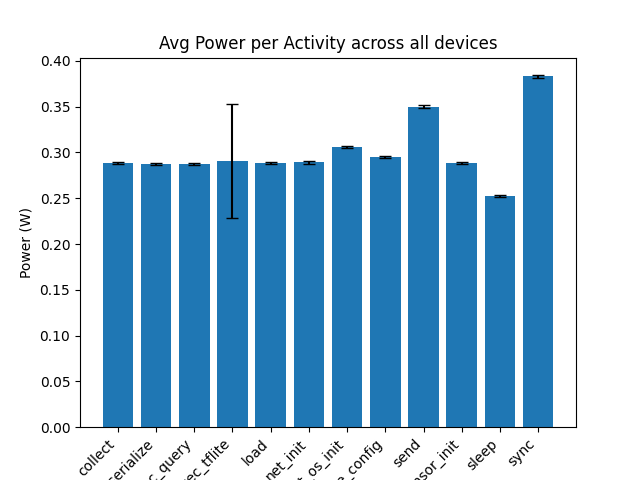

In [45]:

mean_of_loops = power_consumption.groupby(["node_id","activity","loop_num"], observed=True)["power"].mean()
mean_of_activities_of_loops = mean_of_loops.groupby(["activity"], observed=True).mean()
errors = mean_of_loops.groupby(["activity"], observed=True).apply(calc_confidence_interval).unstack(level=-1)
errors_relative = np.abs(errors.T - mean_of_activities_of_loops)
## since error_bounds are absolute and matplotlib likes them relative, we need to substract the mean to get relative error - and take the absolute to flip
## the sign on the lower bound
# print((mean_of_activities_of_loops.repeat(2)).values)
#error_relative = np.abs(errors - mean_of_activities_of_loops)
plt.figure()
plt.bar(mean_of_activities_of_loops.index, mean_of_activities_of_loops.values, yerr=errors_relative.values, capsize=4)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Activity")
plt.ylabel("Power (W)")
plt.title("Avg Power per Activity across all devices")
plt.show()

## remove baseline power consumption from measurements
We assume sleep gives us a good baseline for low power consumption so to make clearer the differences between periods we subtract sleep

In [46]:
sleep_baseline = power_consumption[power_consumption["activity"] == "sleep"]["power"].mean()
# this takes the average of all sleep measurement which is different than the average worked with so far,
# which is the average per activity per loop averaged for all loops
sleep_baseline

0.25274116

In [47]:
## check how the data now looks. we ignore the sleep and uncategorised
power_consumption["power_without_sleep"] = power_consumption["power"] - sleep_baseline
power_consumption[(power_consumption["activity"] != "sleep") & (power_consumption["activity"] != "uncategorised")]["power_without_sleep"].describe()

count    1.611155e+06
mean     8.436661e-02
std      8.004917e-02
min     -7.692516e-02
25%      2.441284e-02
50%      4.638985e-02
75%      8.484983e-02
max      2.856948e-01
Name: power_without_sleep, dtype: float64

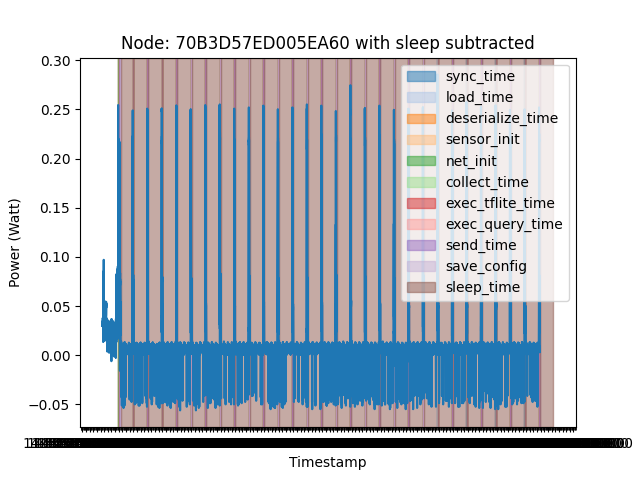

In [48]:
## plot a node with the new data with activities
node_id = nodes_with_queries.iloc[0]["node_id"]
timing_data = loops[loops["node_id"] == node_id]
power_data = power_consumption[power_consumption["node_id"] == node_id]

plt.figure()
plt.plot(power_data["timestamp"], power_data["power_without_sleep"])
for row in timing_data.itertuples():
    plt.axvspan(row.sync_start, row.sync_end, alpha=alpha, label="sync_time", color=plt.cm.tab20(0))
    plt.axvspan(row.load_start, row.load_end, alpha=alpha, label="load_time", color=plt.cm.tab20(1))
    plt.axvspan(row.deserialize_start, row.deserialize_end, alpha=alpha, label="deserialize_time", color=plt.cm.tab20(2))
    plt.axvspan(row.sensor_init_start, row.sensor_init_end, alpha=alpha, label="sensor_init", color=plt.cm.tab20(3))
    plt.axvspan(row.net_init_start, row.net_init_end, alpha=alpha, label="net_init", color=plt.cm.tab20(4))
    plt.axvspan(row.collect_time_start, row.collect_time_end, alpha=alpha, label="collect_time", color=plt.cm.tab20(5))
    plt.axvspan(row.exec_tflite_start, row.exec_tflite_end, alpha=alpha, label="exec_tflite_time", color=plt.cm.tab20(6))
    plt.axvspan(row.exec_query_start, row.exec_query_end, alpha=alpha, label="exec_query_time", color=plt.cm.tab20(7))
    plt.axvspan(row.send_start, row.send_end, alpha=alpha, label="send_time", color=plt.cm.tab20(8))
    plt.axvspan(row.save_config_start, row.save_config_end, alpha=alpha, label="save_config", color=plt.cm.tab20(9))
    plt.axvspan(row.sleep_start, row.sleep_end, alpha=alpha, label="sleep_time", color=plt.cm.tab20(10))
# this to remove duplicate labels https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.gca().xaxis.set_major_locator(SecondLocator(interval=30))
plt.gca().xaxis.set_minor_locator(SecondLocator(interval=5))
plt.title(f"Node: {node_id} with sleep subtracted")
plt.xlabel("Timestamp")
plt.ylabel("Power (Watt)")
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M:%S.%f'))  # Set the date format for the tick labels
plt.show()

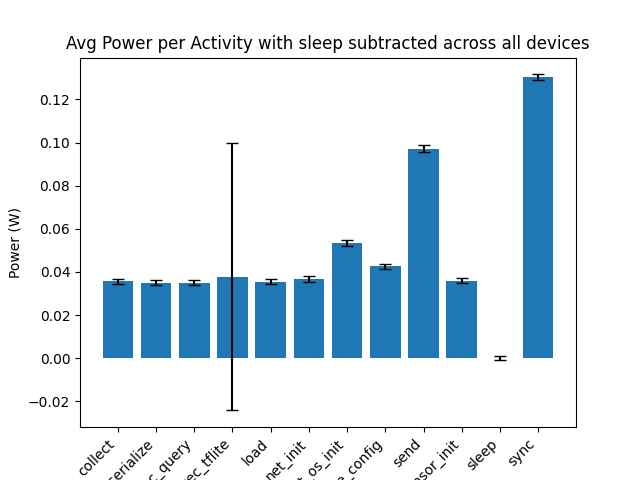

In [49]:
mean_of_loops_without_sleep = power_consumption.groupby(["node_id","activity","loop_num"], observed=True)["power_without_sleep"].mean()
mean_of_activities_of_loops_without_sleep = mean_of_loops_without_sleep.groupby(["activity"], observed=True).mean()
errors = mean_of_loops_without_sleep.groupby(["activity"], observed=True).apply(calc_confidence_interval).unstack(level=-1)
errors_relative = np.abs(errors.T - mean_of_activities_of_loops_without_sleep)
## since error_bounds are absolute and matplotlib likes them relative, we need to substract the mean to get relative error - and take the absolute to flip
## the sign on the lower bound
# print((mean_of_activities_of_loops.repeat(2)).values)
#error_relative = np.abs(errors - mean_of_activities_of_loops)
plt.figure()
plt.bar(mean_of_activities_of_loops_without_sleep.index, mean_of_activities_of_loops_without_sleep.values, yerr=errors_relative.values, capsize=4)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Activity")
plt.ylabel("Power (W)")
plt.title("Avg Power per Activity with sleep subtracted across all devices")
plt.show()

In [50]:
## lets look at time consumption per activity
grouped_timestamps = power_consumption[(power_consumption["activity"] != "uncategorised") & (power_consumption["node_id"].isin(nodes_with_queries["node_id"]))].groupby(["node_id","activity","loop_num"], observed=True)["timestamp"]
duration_of_activity_per_nodeid_activity_loopnum = grouped_timestamps.max() - grouped_timestamps.min()
duration_of_activity_per_nodeid_activity_loopnum.rename("duration", inplace=True)

#and then take mean of loops for each node_id,activity. and also calculate CI
grouped = duration_of_activity_per_nodeid_activity_loopnum.groupby(["node_id","activity"], observed=True)
mean_duration_of_activity_per_nodeid_activity = grouped.mean()

mean_duration_of_activity_per_nodeid_activity_ci = pd.to_timedelta(grouped.apply(lambda x: calc_confidence_interval(pd.to_numeric(x))), unit="us").unstack(-1)


errors_relative = mean_duration_of_activity_per_nodeid_activity_ci.sub(mean_duration_of_activity_per_nodeid_activity, axis=0).abs()


# since matplotlib and pandas are annoying we have to construct the plot to get the error bars
x_labels = mean_duration_of_activity_per_nodeid_activity.index.get_level_values(1).unique()
locations = np.arange(len(x_labels))
width = 1 / len(x_labels)
multiplier = 0

grouped = mean_duration_of_activity_per_nodeid_activity.groupby("node_id", observed=True)

plt.figure()
for node_id, group in grouped:
    group = group.astype("timedelta64[ns]").values
    yerrs = errors_relative.loc[idx[node_id,:]].T.values
    offset = width * multiplier
    plt.bar(locations+offset, group, width=width, label=node_id, yerr=errors_relative.loc[idx[node_id,:]].T.values, log=False, capsize=4)
    multiplier += 1

plt.xticks(ticks=locations+width, labels=x_labels, rotation=45)
plt.xlabel("Activity")
plt.ylabel("Duration (ns)")
plt.title("Avg Duration per Activity per device")
plt.legend()
plt.show()


/home/kasper/.local/lib/python3.10/site-packages/statsmodels/stats/weightstats.py:228: RuntimeWarning: invalid value encountered in scalar divide
  return std / np.sqrt(self.sum_weights - 1)


In [ ]:
## now that we can see they are extremely similar, lets take an average across all devices
duration_results = duration_of_activity_per_nodeid_activity_loopnum.groupby(["activity"], observed=True).mean().copy()
#convert the timings to raw ms
# add _duration suffix to categorical index
duration_results.index = duration_results.index.rename_categories([f"{cat}_duration_us" for cat in duration_results.index.categories])
duration_results = duration_results.apply(lambda x: int(x / pd.Timedelta("1us")))


energy_results = mean_of_activities_of_loops_without_sleep.copy()
energy_results.index = energy_results.index.rename_categories([f"{cat}_watts" for cat in energy_results.index.categories])
current_results = pd.DataFrame(pd.concat([duration_results, energy_results])).T
current_results.columns.name = None
current_results["experiment_id"] = int(EXP_ID)

#read the existing csv file "results" and combine with current results

import os
if os.path.exists("results.csv"):
    results = pd.read_csv("results.csv",header=0)
    results = pd.concat([results,current_results], join="inner", axis=0)
    results = results.drop_duplicates(subset="experiment_id")
    results = results.set_index("experiment_id")
    results = results.sort_index()
    results.to_csv("results.csv")
    
else:
    current_results.to_csv("results.csv")


## initial model thoughts
The Energy consumed is roughly the average power in activity times length of activity. All energy consumed during activities are affected by outside factors as either their power or length is affected. However most are amortized constant. Here is an overview:

- **Riot OS initialization**: constant

    Riot needs to boot. This takes some time and power.

- **sync**: constant

    Only applicable for testing, so removed in real-world scenario
    

- **load**: dependent on query length

    Loads network configuration (constant time) and serialized query (dependent on query length)


- **deserialize**: dependent on query length

    If there is a query, deserialize it. This should probably be classified under load, even though it technically happens in different places in Terra


- **sensor_init**: Mostly constant. depend on sensors

    initialises sensors and their communication channels. Some sensors require no initialization, while others have boot-up times, calibration or others that require varying amounts of power and time.  


- **net_init**: amortized constant.

    Initialises network. If not connected, this requires a power and time costly OTAA procedure that is highly dependent on environment. If already connected, this is a constant time OS initialization.

- **sensor_collect**: Mostly constant. depend on sensors

    Collection of sensor values. some sensors is a simple constant time read. Others need to perform activities like running a fan until some threshold is passed. 


- **exec**: dependent on query length and tflite complexity

    - tflite might have a fixed constant cost or be more flexible. More testing needed
    - query length might have a fixed constant cost or be more flexible. More testing needed



- **send**: dependent on query, filter selectivity and guaranteed send parameter

    send is highly dependent on number of results to transmit and if a query passes a filter or not. and on environment.


- **save_config**: dependent on query length

    Could possibly also go under a new variable called "ConfigHandling" or the like


- **sleep**: dependent on all others

    However we assume this is the lowest possible power state so nothing can be done about this


each of the above points can be a parameter in the energy model, and their absolute power cost will be either a constant or a factor times the baseline power consumption. The values for these have to be derived experimentally and are unique per device model

Given the info above we produce the formula below

$$
\text{Epoch}_{Energy} = \text{LoadConfig}_{time}\cdot\text{LoadConfig}_{power} + \text{Deserialize}_{time}\cdot\text{Deserialize}_{power} +  \text{SensorInit}_{time}\cdot\text{SensorInit}_{power}+ \text{NetInit}_{time}\cdot\text{NetInit}_{power} + \text{SensorCollect}_{time}\cdot\text{SensorCollect}_{power}+ \text{Exec}_{time}\cdot\text{Exec}_{power} + \text{Send}_{time}\cdot\text{Send}_{power}+ \text{SaveConfig}_{time}\cdot\text{SaveConfig}_{power}
$$

## Calculate Total Energy Consumed per activity

In [ ]:
#define function to calculate energy consumed
def calc_energy_consumed(df: pd.DataFrame):
    """
    calculate energy consumed in the given dataframe. Assumes the times are in index and is of type pd.DatetimeIndex and power is in column "power"
    Assumes power is in W
    :param df: dataframe with power consumption
    :return: energy consumed in the unit of W times s or J
    """
    # create a copy of the dataframe with only index and power
    if len(df) == 0:
        return 0
    #     # ensure we only calculate for data frames containing data from a single node
    # assert len(df["node_id"].unique()) == 1, "energy consumption only supported for single node"

    # # assert df have columns "power" and index of "timestamp" type
    # assert "power" in df.columns, "power column not found"
    # assert isinstance(df.index, pd.DatetimeIndex), "index is not  of type pd.DatetimeIndex"
    times = df.index.values
    powers = df["power"].values

    #power["power_diff"] = power.diff().shift(-1) #  current - previous, shifted one back so it becomes next - current. i.e. current + diff = next
    time_diff= np.abs(np.diff(times)) # abs(next-current)
    time_diff_s = time_diff / np.timedelta64(1, 's') # get timediff in fractions of a second
    powers = powers[:-1] # drop last row since it has no next and doesnt match up with the time_diff
    return np.sum(powers * time_diff_s) # returns the sum of power times fractions of a second. Since power is in W and time_diff_s is in seconds it is in W*s or J


In [ ]:
# loops contain the start and end times of each activity, so loop over loops and calculate the energy for each activity
def calc_energy_consumed_per_activity(series_loops: pd.Series) -> pd.Series:
    power_consumption_for_node = power_consumption[(power_consumption["node_id"] == series_loops["node_id"])]
    power_consumption_for_node.set_index("timestamp", inplace=True)
    return pd.Series({
        "node_id": series_loops["node_id"],
        "loop_num": series_loops["loop_num"],
        "total": calc_energy_consumed(power_consumption_for_node.loc[series_loops["start_time"]:series_loops["sleep_end"]]),
        "loop signal": calc_energy_consumed(power_consumption_for_node.loc[series_loops["start_time"]:series_loops["loop_signal_end"]]),
        "total without loop signal": calc_energy_consumed(power_consumption_for_node.loc[series_loops["loop_signal_end"]:series_loops["sleep_end"]]),
        "load config": calc_energy_consumed(power_consumption_for_node.loc[series_loops["load_start"]:series_loops["load_end"]]),
        "deserialize": calc_energy_consumed(power_consumption_for_node.loc[series_loops["deserialize_start"]:series_loops["deserialize_end"]]),
        "sensor init": calc_energy_consumed(power_consumption_for_node.loc[series_loops["sensor_init_start"]:series_loops["sensor_init_end"]]),
        "net init": calc_energy_consumed(power_consumption_for_node.loc[series_loops["net_init_start"]:series_loops["net_init_end"]]),
        "sensor collect": calc_energy_consumed(power_consumption_for_node.loc[series_loops["collect_time_start"]:series_loops["collect_time_end"]]),
        "tflite execution": calc_energy_consumed(power_consumption_for_node.loc[series_loops["exec_tflite_start"]:series_loops["exec_tflite_end"]]),
        "query execution": calc_energy_consumed(power_consumption_for_node.loc[series_loops["exec_query_start"]:series_loops["exec_query_end"]]),
        "send": calc_energy_consumed(power_consumption_for_node.loc[series_loops["send_start"]:series_loops["send_end"]]),
        "save config": calc_energy_consumed(power_consumption_for_node.loc[series_loops["save_config_start"]:series_loops["save_config_end"]]),
        "sleep": calc_energy_consumed(power_consumption_for_node.loc[series_loops["sleep_start"]:series_loops["sleep_end"]]),
    })
energy_consumed = loops.apply(calc_energy_consumed_per_activity, axis=1)
energy_consumed_summary = energy_consumed.describe()
energy_consumed_summary

In [ ]:
energy_consumed.head()

In [ ]:
# define the columns we want to work with. Note that since we dont include node_id we effectively remove the individual nodes from the calculations
columns_without_totals = ["loop signal", "load config", "deserialize", "sensor init", "net init", "sensor collect","tflite execution", "query execution", "send", "save config", "sleep"]
columns = ["total", "total without loop signal"] + columns_without_totals

In [ ]:
error_bounds = energy_consumed[columns].apply(calc_confidence_interval)
error_bounds

In [ ]:
# plot barchart with stddev error bars
plt.figure()
to_plot = energy_consumed_summary[columns]

## since error_bounds are absolute and matplotlib likes them relative, we need to substract the mean to get relative error - and take the absolute to flip
## the sign on the lower bound
error_relative = np.abs(error_bounds - to_plot.loc["mean"])

plt.bar(to_plot.columns, to_plot.loc["mean"], yerr=error_relative,capsize=4)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.xlabel("Activity")
plt.ylabel("Energy (J)")
plt.title("Energy Consumed per Activity across all devices including totals")
plt.show()

In [ ]:
# plot barchart without totals 
plt.figure()
to_plot = energy_consumed_summary[columns_without_totals]
error_relative = np.abs(error_bounds[columns_without_totals] - to_plot.loc["mean"])
plt.bar(to_plot.columns, to_plot.loc["mean"], yerr=error_relative, log=True, capsize=4)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.xlabel("Activity")
plt.ylabel("Energy (J)")
plt.title("Energy Consumed per Activity across all devices")
plt.show()

In [ ]:
# plot barchart without totals and without the 0th loop
# recalc summary without 0 loops
without_0th_loop = loops[loops["loop_num"] > 0].apply(calc_energy_consumed_per_activity, axis=1)
without_0th_loop_summary = without_0th_loop.describe()

In [ ]:
error_bounds_without_0th_loop = without_0th_loop[columns].apply(calc_confidence_interval)


In [ ]:
to_plot = without_0th_loop_summary[columns_without_totals]

errors_relative = np.abs(error_bounds_without_0th_loop[columns_without_totals] - to_plot.loc["mean"])
#energy_consumed_without_0th_loop
## plot both with log scale and without
fig, (ax1, ax2) =  plt.subplots(1,2)

fig.suptitle("Energy Consumed per Activity across all devices without 0th loop")
fig.supxlabel("Activity")
fig.supylabel("Energy (J)")

ax1.bar(to_plot.columns, to_plot.loc["mean"], yerr=errors_relative, capsize=4, log=True)
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")
ax2.bar(to_plot.columns, to_plot.loc["mean"], yerr=errors_relative, capsize=4)
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right")



plt.tight_layout()
plt.show()

In [ ]:
without_0th_loop.groupby("node_id").describe()

In [ ]:
## plot per node
grouped = without_0th_loop[['node_id'] + columns_without_totals] \
    .groupby("node_id")
# grouped_agg = grouped.agg(["mean", "std"])
# def hej(row: pd.Series):
#     outermost_column = list(set(k[0] for k in row.keys()))
#     idx = pd.MultiIndex.from_product([outermost_column, ["low","high"]])
#     res = pd.Series(index=idx)
#     for col in outermost_column:
#         res[col] = calc_confidence_interval(row[col])
#     return res
# ci = grouped_agg.apply(hej, axis=1)

In [ ]:
locations = np.arange(len(columns_without_totals))
width = 0.05
multiplier = 0
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
for node_id, row in grouped:
    values = row[columns_without_totals].mean().values
    error_bounds = row[columns_without_totals].apply(calc_confidence_interval)
    errors_relative = np.abs(error_bounds - values)
    #values = row.loc[node_id,(slice(None),"mean")][columns].values
    #errors_low = values - ci.loc[node_id,(slice(None),"low")][columns]
    #errors_high = ci.loc[node_id,(slice(None),"high")][columns] - values
    # for node_id, mean in row.loc[activity,"mean"].items():
    offset = width * multiplier

    rects = ax.bar(locations + offset, values, width, capsize=2, label=node_id, yerr=errors_relative, log=True)
    #ax.bar_label(rects, padding=3)
    multiplier += 1
ax.legend(title="Node ID")
ax.set_title("Energy consumed per activity per device without connection establishment loop")
ax.set_ylabel("Energy (J)")
ax.set_xlabel("Activity")
ax.set_xticks(locations + 0.25, columns_without_totals, rotation=20, ha="right")
plt.show()

In [ ]:

#TODO: vis distribution over query execution means
# IFT: 2 modaliteter: selectivity på filtre. lav exp med forskl. selectivity og regression til cost model
# størrelse af query: save cost afhænger af query størrelse

# TODO: from Viktor
# before doing the above try to from the data you have derive a power consumption per time period and estimate the powerconsumption linearly based on the time the activity takes
